<a href="https://colab.research.google.com/github/prasama/ear/blob/main/Training_a_lightning_nowcasting_model_with_GOES_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using machine learning to train a lightning nowcasting model



*   Creator(s): John Cintineo
*   Affiliation(s): Cooperative Institute of Meteorological Satellite Studies (CIMSS), University of Wisconsin -- Madison (UW-Madison)
*  History:
  * Created: August 2023

<hr>

## Overview
In this notebook, we explore how to use NOAA's Geostationary Operational Environmental Satellite -- R series (GOES-R) data to predict the probability of lightning in the short term (0-1 hour). Because of the very short forecast window, this is also called  "nowcasting".

### Prerequisites
To successfully navigate and use this notebook, you should be accustomed with:

*   The basics of Python programming (e.g., loading modules, variable assignment, plotting, familiarity with scientific Python packages)
*   Introductory statistics and linear algebra (e.g., statistical metrics, probability)
*   A basic familiarity with GOES-R instruments (not required)

### Learning Outcomes
By working through this notebook, you should have:

*  A basic understanding of the lexicon for machine learning
*  Familiarity with validation metrics like critical success index
*  Knowledge with how to generate and utilize TFRecords
*  Background in identifying overfitting and underfitting

### Expected Completion time
*  Active use: 30 minutes
*  Passive use: 70 minutes (waiting for data fetching, etc.)
   *  You should use a GPU when [Tranining the Model](#training_model)
      *  If necessary, Runtime --> Change runtime type --> select GPU
      *  Changing runtime type clears all data and executions
*  Total time: 100 minutes

<hr>




# Tutorial

## Background

The [daytime cloud-phase distinction](https://rammb.cira.colostate.edu/training/visit/quick_guides/QuickGuide_DayCloudPhaseDistinction_final_v2.pdf) red-green-blue (RGB) false-color imagery is used by forecasters to discern glaciation in clouds. Glaciation is an important indicator of ice and mixed-phase regions forming in convection, often resulting in the separation of charge through collisions of particles. Large charge separations result in lightning.

Take a look at this image. In this scene, yellow-to-orange regions correspond to ice clouds. Dark blue is land surface. Light blue represent water clouds. And importantly, greenish clouds represent clouds with mixed phase regions and those that are glaciating (ice cloud-tops).

ABI's 0.64-µm reflectance (**CH02**), 1.6-µm reflectance (**CH05**), and 10.3-µm brightness temperature (**CH13**) comprise the daytime cloud-phase distinction RGB. In addition, the 12.3-µm brightness temperature (**CH15**) is important in the cloud height algorithm, so we hypothesize that it may help in nowcasting lightning. Thus, we will look at these four channels as our predictors.

We will focus on extracting the glaciation and cloud height singals from weather satellite imagery using a convolutional neural network (CNN). Furthermore, the CNN should help us extract other salient spatial features that we may not be aware of.

<img src="https://cimss.ssec.wisc.edu/severe_conv/training/DCPD.png">

## The Problem

An important consideration is to pose your problem well. What exactly do you want to predict? What datasets are available to you? What are the advantages and disadvantages of each? What about availility? It is also good to consider any "operational" aspects that may be important. For instance, if you need to make near-real time predictions, is the data you select available in a near-real time basis? Do you expect that data to persist well into the future? Answering these questions can really help you get started and work towards a successful model.

For our project, we want to be able to predict lightning before it occurs. Specifically, we want to predict the _probability_ of lightning within the next hour from a satellite data scan.


## Datasets

We will use [GOES-R](https://www.goes-r.gov/) [ABI](https://https://www.goes-r.gov/education/docs/Factsheet_ABI.pdf) data to train our model. That is, all predictors will come from the GOES-R geostationary satellites. We use geostationary satellite data so that we get rapid updates (between 1 and 10 minutes).

Furthermore, ABI data can give us observations of clouds before there is precipitation, and thus we may be able to discern lightning potential before any radar echoes are present in convection.

We will use GOES-R's [Geostationary Lightning Mapper](https://https://www.goes-r.gov/education/docs/Factsheet_GLM.pdf) (GLM) as the "target" or "truth" data. This is a spaceborn optical sensor. A big advantage is that it can "map" out the footprint of a lightning strike, rather than just provide one lat/lon centroid. The downside is that it has a rather coarse spatial resolution (~8-10 km). However, we think predicting the spatial component of lightning is important, so let's go with GLM data.

## Software
This tutorial uses the Python programming language and scientific Python packages. We will primarily use:

- `netCDF4` and `xarray` to read in our datasets
- `tensorflow` for machine learning
- `glmtools` for making gridded GLM fields
- scikit-learn (`sklean`) and `scipy` for statistical metrics
- `matplotlib` for visualizing our data

## Building glmtools
We will need to use the glmtools package to create gridded GLM fields, such as flash-extent density. Please note that the commands below to install glmtools will likely be a little different in Google Colab than on your home machine (e.g., installing mamba). So, we refer you to the [glmtools github page](https://github.com/deeplycloudy/glmtools/tree/master) to install that package.

Here we also install `s3fs` for reading from AWS S3 buckets, and Python's `netCDF4` package.

The commands below will take 5-10 minutes to execute.

In [ ]:
%%capture
# Python packages that we will use in this notebook
%matplotlib inline

# Install conda for colab
!pip install -q condacolab
import condacolab
condacolab.install()

# Now install mamba, because it's much faster
! conda install -y mamba
! mamba update -qy --all
! mamba clean -qafy

# Install glmtools
!git clone https://github.com/deeplycloudy/glmtools.git
!mamba env create -f glmtools/environment.yml
#This is the odd way we have to use our new python environment
!source activate glmval && pip install -e glmtools/

# Install s3fs for accessing AWS data
!pip install s3fs

# Install netCDF4
!pip install netCDF4


In [ ]:
# Import some packages

# For accessing AWS S3 buckets
import s3fs

# Python Standard Lib
import os
import itertools
from datetime import datetime, timedelta
import collections
import glob
import errno
import pickle
import shutil

# Scientific packages
import netCDF4
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import sklearn
import sklearn.metrics

Here, we connect to S3.

In [ ]:
fs = s3fs.S3FileSystem(anon=True) #connect to s3 bucket!

## Generating gridded GLM data

There may be an easier way to do this, but we need to process the GLM data using `glmtools`. First, we need to download glm files.

Here is a helper function.

In [ ]:
def download_glm_files(bucketpatt):
  #bucketpatt, e.g.: 's3://noaa-goes16/GLM-L2-LCFA/2022/240/20/OR_GLM-L2-LCFA_G16_s2022240200*.nc'
  file_list = fs.glob(f'{bucketpatt}')

  for ff in file_list:
    parts = ff.split('/')
    satellite = parts[0]
    prefix = [f"https://{satellite}.s3.amazonaws.com"]
    url = ('/').join(prefix + parts[1:])
    #print(url)
    os.system(f'wget -q {url}')

### Download GOES-16 GLM L2 Data

Here we make the output directory `glmL2`. Then we download two hours of GLM L2 data. This may take 5-10 minutes.

In [ ]:
!mkdir glmL2
%cd glmL2

download_glm_files('s3://noaa-goes16/GLM-L2-LCFA/2022/240/2[0,1]/OR_GLM-L2-LCFA_G16_s*.nc')

%cd ..

/content/glmL2
/content


### Create 1-minute aggregations of flash-extent density <a name="1minagg"></a>

Now we want to start making hourly accumulations of flashes. These will be our target or "truth" data. We first use `make_GLM_grids.py` to make 1-min flash accumulations. Then, we will use the helper function `aggregate` to make hourly accumulations (note that we are explicitly using our Python executable from our `glmval` environment.

***These steps may take 45 minutes or more.*** It should not take that long on a more capable machine.

In [ ]:
# Make 1-min accumulations for 28 August 2022 2000-2059Z
!/usr/local/envs/glmval/bin/python glmtools/examples/grid/make_GLM_grids.py -o glmL3/1min/{start_time:%Y/%b/%d}/{dataset_name} \
  --fixed_grid --split_events --goes_position=east --goes_sector=conus --dx=2.0 --dy=2.0 \
  glmL2/*s202224020*.nc

In [ ]:
# Make 1-min accumulations for 28 August 2022 2100-2159Z
!/usr/local/envs/glmval/bin/python glmtools/examples/grid/make_GLM_grids.py -o glmL3/1min/{start_time:%Y/%b/%d}/{dataset_name} \
  --fixed_grid --split_events --goes_position=east --goes_sector=conus --dx=2.0 --dy=2.0 \
  glmL2/*s202224021*.nc

Here are some helper functions to aggregate the 1-min flash accumulations into 60-min accumulations.

In [ ]:
# @title
def mkdir_p(path):
  try:
    os.makedirs(path)
  except (OSError,IOError) as exc:
    if exc.errno == errno.EEXIST and os.path.isdir(path):
      pass
    else: raise

#-------------------------------------------------------------------------------------------------------

def write_netcdf(output_file,datasets,dims,atts={},**kwargs):
  print('Process started')

  try:
    mkdir_p(os.path.dirname(output_file))
  except (OSError,IOError) as err:
    print(str(err))
    return False
  else:
    ncfile = netCDF4.Dataset(output_file,'w')

  #dimensions
  for dim in dims:
    ncfile.createDimension(dim,dims[dim])
  #variables
  for varname in datasets:
    try:
      dtype = datasets[varname]['data'].dtype.str
    except AttributeError:
      if(isinstance(datasets[varname]['data'],int)):
        dtype = 'int'
      elif(isinstance(datasets[varname]['data'],float)):
        dtype = 'float'

    if('_FillValue' in datasets[varname]['atts']):
      dat = ncfile.createVariable(varname,dtype,datasets[varname]['dims'],fill_value=datasets[varname]['atts']['_FillValue'])
    else:
      dat = ncfile.createVariable(varname,dtype,datasets[varname]['dims'])
    dat[:] = datasets[varname]['data']
    #variable attributes
    if('atts' in datasets[varname]):
      for att in datasets[varname]['atts']:
        if(att != '_FillValue'): dat.__setattr__(att,datasets[varname]['atts'][att]) #_FillValue is made in 'createVariable'
  #global attributes
  for key in atts:
    ncfile.__setattr__(key,atts[key])
  ncfile.close()
  print('Wrote out ' + output_file)

  return True

#-----------------------------------------------------------------------------------------------------------------------------------

def aggregate_glm_grids(lastdatetime,
                     datadir,
                     accumPeriod=5,
                     outdir=os.environ['PWD']+'/'):


  if(datadir[-1] != '/'): datadir += '/'

  print('Process started')

  try:
    last_dt = datetime.strptime(lastdatetime,'%Y%j%H%M')
  except ValueError as err:
    return False

  #aggregate data for the accumPeriod
  accumMins = 0
  for tt in range(accumPeriod):
    curr_dt = last_dt - timedelta(minutes=tt)
    if(tt==0): ts_dt = curr_dt

    filepattern = datadir + curr_dt.strftime('%Y/%b/%d/OR_GLM-L2-*s%Y%j%H%M*.nc*')

    ncfile = np.sort(glob.glob(filepattern))

    if(len(ncfile)):
      #print(f'received {ncfile[0]}')
      if(tt == 0): #get end datetime of first file in accumulation, since we're working back in time.
        ts_dt = datetime.strptime(os.path.basename(ncfile[0]).split('_e')[1].split('_')[0][0:13],'%Y%j%H%M%S')
      accumMins += 1
      ncfile = ncfile[0]
      nc = netCDF4.Dataset(ncfile,'r')


      flash_extent_density_TMP = nc.variables['flash_extent_density'][:]

      average_area_perflash = nc.variables['average_flash_area'][:]
      average_area_TMP = np.multiply(average_area_perflash,flash_extent_density_TMP)

      group_extent_density_TMP = nc.variables['group_extent_density'][:]

      average_area_pergroup = nc.variables['average_group_area'][:]
      average_garea_TMP = np.multiply(average_area_pergroup,group_extent_density_TMP)

      flash_centroid_density_TMP = nc.variables['flash_centroid_density'][:]

      total_energy_TMP = nc.variables['total_energy'][:] * 1e6 #in nJ...put into fJ

      group_centroid_density_TMP = nc.variables['group_centroid_density'][:]


      #first see if the vars exist (i.e., it's the first iteration if they do not)
      try:
        flash_extent_density
      except NameError:
        #if they do not exist, copy fields
        flash_extent_density = np.copy(flash_extent_density_TMP)
        total_energy = np.copy(total_energy_TMP)
        average_area_AGG = np.copy(average_area_TMP)
        average_garea_AGG = np.copy(average_garea_TMP)
        flash_centroid_density = np.copy(flash_centroid_density_TMP)
        group_extent_density = np.copy(group_extent_density_TMP)
        group_centroid_density = np.copy(group_centroid_density_TMP)
        ydim = nc.dimensions['y'].size
        xdim = nc.dimensions['x'].size
        min_flash_area_grids = np.zeros((accumPeriod,ydim,xdim))
        min_flash_area_grids[tt] = nc.variables['minimum_flash_area'][:]
        #and grab x and y
        x = np.array(nc['x'][:])
        y = np.array(nc['y'][:])
        gip = nc['goes_imager_projection'][:]
      else:
        #if they do exist, just aggregate fields
        try:
          flash_extent_density += flash_extent_density_TMP
          total_energy += total_energy_TMP
          average_area_AGG += average_area_TMP
          average_garea_AGG += average_garea_TMP
          flash_centroid_density += flash_centroid_density_TMP
          group_extent_density += group_extent_density_TMP
          group_centroid_density += group_centroid_density_TMP
          min_flash_area_grids[tt] = nc.variables['minimum_flash_area'][:]
        except ValueError as err:
          logging.error(traceback.format_exc())
          nc.close()
          return False

      #get attributes
      try:
        vatts
        gatts
      except NameError:
        vatts = collections.OrderedDict()
        vatts['x'] = {}
        vatts['y'] = {}
        vatts['goes_imager_projection'] = {}
        vatts['flash_extent_density'] = {}
        vatts['flash_centroid_density'] = {}
        vatts['total_energy'] = {}
        vatts['average_flash_area'] = {}
        vatts['group_extent_density'] ={}
        vatts['group_centroid_density'] = {}
        vatts['average_group_area'] = {}
        vatts['minimum_flash_area'] = {}
        for var in vatts:
          for att in nc.variables[var].ncattrs():
            vatts[var][att] = nc.variables[var].getncattr(att)
        vatts['total_energy']['units'] = 'fJ'
        vatts['total_energy']['scale_factor'] = 1
        vatts['total_energy']['add_offset'] = 0
        vatts['average_flash_area']['units'] = 'km^2'
        vatts['average_group_area']['units'] = 'km^2'

        #global atts
        gatts = collections.OrderedDict()
        gatts['spatial_resolution'] = getattr(nc,'spatial_resolution')
        gatts['subsatellite_longitude'] = vatts['goes_imager_projection']['longitude_of_projection_origin']
        gatts['orbital_slot'] = getattr(nc,'orbital_slot')
        gatts['platform_ID'] = getattr(nc,'platform_ID')
        gatts['scene_id'] = gatts['orbital_slot'][5] + getattr(nc,'scene_id') #gatts['orbital_slot'][5] is "E" or "W"
        gatts['time_coverage_end'] = getattr(nc,'time_coverage_end')

      #do every time
      gatts['time_coverage_start'] = getattr(nc,'time_coverage_start')

      #close ncfile
      nc.close()


  if(accumMins == 0): return False
  gatts['aggregation'] = str(accumMins) + ' min'
  gatts['dataset_name'] = "GLM_gridded_data"

  for var in ['flash_extent_density','flash_centroid_density','group_extent_density','group_centroid_density']:
    attparts = vatts[var]['units'].split(' ')
    attparts[-2] = str(accumMins)
    vatts[var]['units'] = (' ').join(attparts)

  #Make final min area
  fillv = 999999
  min_flash_area_grids[min_flash_area_grids == 0] = fillv
  minimum_flash_area = np.min(min_flash_area_grids,axis=0)
  minimum_flash_area[minimum_flash_area == fillv] = 0

  # Make average areas.
  # These steps are necessary so we don't divide by 0 or some small fraction
  average_flash_area = np.zeros((np.shape(average_area_AGG)))
  good_ind = np.where(flash_extent_density >= 1)
  average_flash_area[good_ind] = average_area_AGG[good_ind] / flash_extent_density[good_ind]
  average_flash_area = average_flash_area.astype('f4')

  average_group_area = np.zeros((np.shape(average_garea_AGG)))
  good_ind = np.where(group_extent_density >= 1)
  average_group_area[good_ind] = average_garea_AGG[good_ind] / group_extent_density[good_ind]
  average_group_area = average_group_area.astype('f4')

  ny,nx = np.shape(total_energy)

  #write out data into one file
  #first pack the data using scale_factor and add_offset
  xpacked = ((x - vatts['x']['add_offset'])/vatts['x']['scale_factor']).astype(np.int16)
  ypacked = ((y - vatts['y']['add_offset'])/vatts['y']['scale_factor']).astype(np.int16)
  FEDpacked = ((flash_extent_density - vatts['flash_extent_density']['add_offset'])/vatts['flash_extent_density']['scale_factor']).astype(np.int16)
  FCDpacked = ((flash_centroid_density - vatts['flash_centroid_density']['add_offset'])/vatts['flash_centroid_density']['scale_factor']).astype(np.int16)
  TOEpacked = ((total_energy - vatts['total_energy']['add_offset'])/vatts['total_energy']['scale_factor']).astype(np.int16)
  AFApacked = ((average_flash_area - vatts['average_flash_area']['add_offset'])/vatts['average_flash_area']['scale_factor']).astype(np.int16)
  GEDpacked = ((group_extent_density - vatts['group_extent_density']['add_offset'])/vatts['group_extent_density']['scale_factor']).astype(np.int16)
  GCDpacked = ((group_centroid_density - vatts['group_centroid_density']['add_offset'])/vatts['group_centroid_density']['scale_factor']).astype(np.int16)
  AGApacked = ((average_group_area - vatts['average_group_area']['add_offset'])/vatts['average_group_area']['scale_factor']).astype(np.int16)
  MFApacked = ((minimum_flash_area - vatts['minimum_flash_area']['add_offset'])/vatts['minimum_flash_area']['scale_factor']).astype(np.int16)

  dims = collections.OrderedDict(); dims['y'] = ny; dims['x'] = nx
  datasets = collections.OrderedDict()
  datasets['x'] = {'data':xpacked,'dims':('x'),'atts':vatts['x']}
  datasets['y'] = {'data':ypacked,'dims':('y'),'atts':vatts['y']}
  datasets['goes_imager_projection'] = {'data':gip,'dims':(),'atts':vatts['goes_imager_projection']}
  datasets['flash_extent_density'] = {'data':FEDpacked,'dims':('y','x'),'atts':vatts['flash_extent_density']}
  datasets['flash_centroid_density'] = {'data':FCDpacked,'dims':('y','x'),'atts':vatts['flash_centroid_density']}
  datasets['total_energy'] = {'data':TOEpacked,'dims':('y','x'),'atts':vatts['total_energy']}
  datasets['average_flash_area'] = {'data':AFApacked,'dims':('y','x'),'atts':vatts['average_flash_area']}
  datasets['group_extent_density'] = {'data':GEDpacked,'dims':('y','x'),'atts':vatts['group_extent_density']}
  datasets['group_centroid_density'] = {'data':GCDpacked,'dims':('y','x'),'atts':vatts['group_centroid_density']}
  datasets['average_group_area'] = {'data':AGApacked,'dims':('y','x'),'atts':vatts['average_group_area']}
  datasets['minimum_flash_area'] = {'data':MFApacked,'dims':('y','x'),'atts':vatts['minimum_flash_area']}

  grid_outdir = outdir + '/agg/'

  timestamp = ts_dt.strftime('%Y%m%d-%H%M%S')
  epoch_secs = int((ts_dt - datetime.utcfromtimestamp(0)).total_seconds())
  outfile = grid_outdir + timestamp + '.netcdf'

  status = write_netcdf(outfile,datasets,dims,atts=gatts)

#-------------------------------------------------------------------------------------------------------------------------------------------------

### Create 60-minute accumulations of flash-extent density

Now make 60-minute accumulations from the 1-minute files. Each pixel will sum up all the flashes from 60 minutes *before* `lastdt_str` up to `lastdt_str`. We only create an output file every 5 minutes to correspond with the GOES-R CONUS data, which has 5-minute temporal resolution. This may take 10 minutes or so.

In [ ]:
datadir = 'glmL3/1min/'
outdir = 'glmL3/60min'

startdt = dt = datetime(2022,8,28,21,0)
enddt = datetime(2022,8,28,22,0)

while startdt <= dt < enddt:
  lastdt_str = dt.strftime('%Y%j%H%M')
  aggregate_glm_grids(lastdt_str,datadir,accumPeriod=60,outdir=outdir)
  dt += timedelta(minutes=5)

Process started
Process started
Wrote out glmL3/60min/agg/20220828-210100.netcdf
Process started
Process started
Wrote out glmL3/60min/agg/20220828-210600.netcdf
Process started
Process started
Wrote out glmL3/60min/agg/20220828-211100.netcdf
Process started
Process started
Wrote out glmL3/60min/agg/20220828-211600.netcdf
Process started
Process started
Wrote out glmL3/60min/agg/20220828-212100.netcdf
Process started
Process started
Wrote out glmL3/60min/agg/20220828-212600.netcdf
Process started
Process started
Wrote out glmL3/60min/agg/20220828-213100.netcdf
Process started
Process started
Wrote out glmL3/60min/agg/20220828-213600.netcdf
Process started
Process started
Wrote out glmL3/60min/agg/20220828-214100.netcdf
Process started
Process started
Wrote out glmL3/60min/agg/20220828-214600.netcdf
Process started
Process started
Wrote out glmL3/60min/agg/20220828-215100.netcdf
Process started
Process started
Wrote out glmL3/60min/agg/20220828-215600.netcdf


In [ ]:
# Check that you have aggregated GLM files
!ls glmL3/60min/agg

20220828-210100.netcdf	20220828-212100.netcdf	20220828-214100.netcdf
20220828-210600.netcdf	20220828-212600.netcdf	20220828-214600.netcdf
20220828-211100.netcdf	20220828-213100.netcdf	20220828-215100.netcdf
20220828-211600.netcdf	20220828-213600.netcdf	20220828-215600.netcdf


### Visualize target/truth data
Now, let's visualize one of our files. This will be an example of our targets---next-hour lightning!

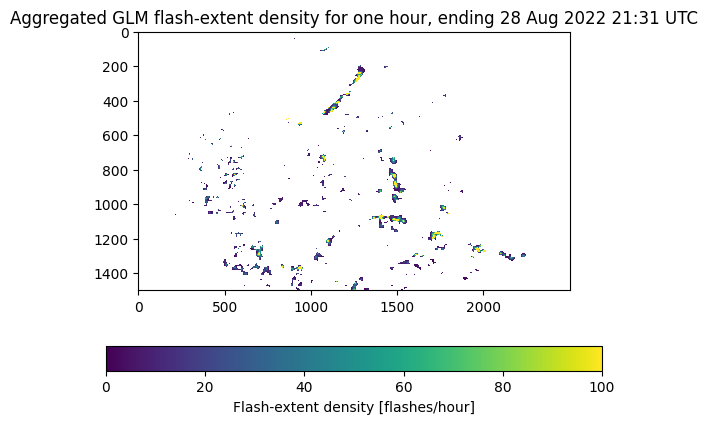

In [ ]:
filename = 'glmL3/60min/agg/20220828-213100.netcdf'
dt = datetime.strptime(os.path.basename(filename),'%Y%m%d-%H%M00.netcdf')
nc = netCDF4.Dataset(filename)
data = nc.variables['flash_extent_density'][:]
nc.close()
plt.imshow(data,vmin=0,vmax=100)
plt.title(f'Aggregated GLM flash-extent density for one hour, ending {dt.strftime("%d %b %Y %H:%M")} UTC')
cbar = plt.colorbar(orientation='horizontal',label='Flash-extent density [flashes/hour]')
plt.show()

## Visualize GOES-16 ABI data

Now let's look at some our predictor data. We will access this data through AWS's S3 buckets. Note that this is just an example datetime--not directly from our training dataset.

After we grab the data we need, we convert CH02 and CH05 to reflectances, and CH13 and CH15 to brightness temperatures.

In [ ]:
abidt = datetime(2020,8,10,18,1)

#CH02
file_location = fs.glob(abidt.strftime('s3://noaa-goes16/ABI-L1b-RadC/%Y/%j/%H/*C02*_s%Y%j%H%M*.nc'))
file_ob = [fs.open(file) for file in file_location]
ds = xr.open_mfdataset(file_ob,combine='nested',concat_dim='time')
ch02 = ds['Rad'][0].data.compute()
ch02 = ch02 * ds['kappa0'].data[0] # Convert to reflectance

#CH05
file_location = fs.glob(abidt.strftime('s3://noaa-goes16/ABI-L1b-RadC/%Y/%j/%H/*C05*_s%Y%j%H%M*.nc'))
file_ob = [fs.open(file) for file in file_location]
ds = xr.open_mfdataset(file_ob,combine='nested',concat_dim='time')
ch05 = ds['Rad'][0].data.compute()
ch05 = ch05 * ds['kappa0'].data[0] # Convert to reflectance

#CH13
file_location = fs.glob(abidt.strftime('s3://noaa-goes16/ABI-L1b-RadC/%Y/%j/%H/*C13*_s%Y%j%H%M*.nc'))
file_ob = [fs.open(file) for file in file_location]
ds = xr.open_mfdataset(file_ob,combine='nested',concat_dim='time')
ch13 = ds['Rad'][0].data.compute()
# Convert to brightness temperature
# First get some constants
planck_fk1 = ds['planck_fk1'].data[0]; planck_fk2 = ds['planck_fk2'].data[0]; planck_bc1 = ds['planck_bc1'].data[0]; planck_bc2 = ds['planck_bc2'].data[0]
ch13 = (planck_fk2 / (np.log((planck_fk1 / ch13) + 1)) - planck_bc1) / planck_bc2

#CH15
file_location = fs.glob(abidt.strftime('s3://noaa-goes16/ABI-L1b-RadC/%Y/%j/%H/*C15*_s%Y%j%H%M*.nc'))
file_ob = [fs.open(file) for file in file_location]
ds = xr.open_mfdataset(file_ob,combine='nested',concat_dim='time')
ch15 = ds['Rad'][0].data.compute()
# Convert to brightness temperature
# First get some constants
planck_fk1 = ds['planck_fk1'].data[0]; planck_fk2 = ds['planck_fk2'].data[0]; planck_bc1 = ds['planck_bc1'].data[0]; planck_bc2 = ds['planck_bc2'].data[0]
ch15 = (planck_fk2 / (np.log((planck_fk1 / ch15) + 1)) - planck_bc1) / planck_bc2


Now we plot the data.

Text(0.5, 1.0, 'GOES-16 ABI CH15 brightness temperature')

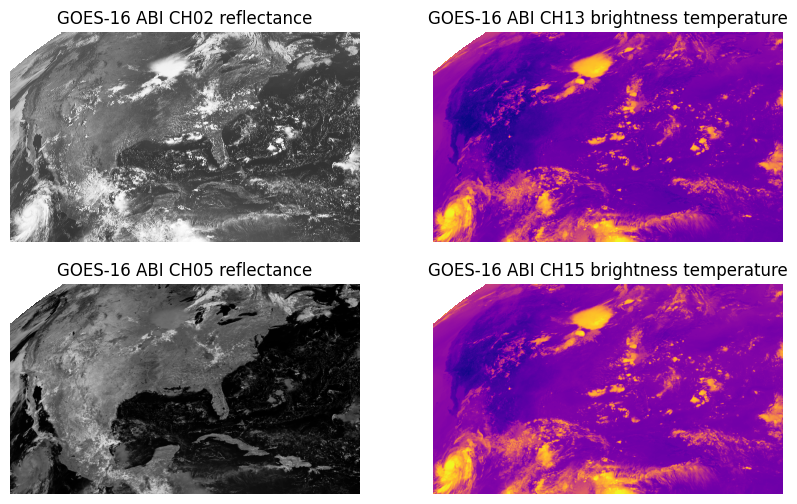

In [ ]:
fig,axes = plt.subplots(nrows=2, ncols=2, figsize=(10,6))

ax = axes[0,0]; ax.axis('off')
ax.imshow(np.sqrt(ch02),vmin=0,vmax=1,cmap=plt.get_cmap("Greys_r")) #We apply a square-root enhancement to ch02
ax.set_title('GOES-16 ABI CH02 reflectance')

ax = axes[1,0]; ax.axis('off')
ax.imshow(ch05,vmin=0,vmax=0.75,cmap=plt.get_cmap("Greys_r"))
ax.set_title('GOES-16 ABI CH05 reflectance')

ax = axes[0,1]; ax.axis('off')
ax.imshow(ch13,vmin=200,vmax=320,cmap=plt.get_cmap("plasma_r"))
ax.set_title('GOES-16 ABI CH13 brightness temperature')

ax = axes[1,1]; ax.axis('off')
ax.imshow(ch15,vmin=200,vmax=320,cmap=plt.get_cmap("plasma_r"))
ax.set_title('GOES-16 ABI CH15 brightness temperature')

Note how deep convective clouds are cold in the longwave infrared (orange in CH13 and CH15) and bright in visible wavelengths (white in CH02). Note also how deep convective cloud tops are more gray in the shortwave infrared CH05. In this channel, ice clouds are gray because they reflect less light, but water clouds are white, reflecting more light back to the ABI instrument.

## Generating TFRecords

Now that we have our GLM target data how we want it, and we've taken a look at our predictor data from ABI, we can begin creating TFRecords that will contain the truth/target GLM data and predictor data from GOES-16 ABI.

[TFRecords](https://www.tensorflow.org/tutorials/load_data/tfrecord) are Tensorflow's binary data format. They are probably the most efficient way to load data to GPUs via Tensorflow's Dataset object. That said, there are many ways to send data to GPUs for training.

Some helper functions:

In [ ]:
import tensorflow as tf

def bytescale(data_arr,vmin,vmax):
    assert(vmin < vmax)
    DataImage = np.round((data_arr - vmin) / (vmax - vmin) * 255.9999)
    DataImage[DataImage < 0] = 0
    DataImage[DataImage > 255] = 255
    return DataImage.astype(np.uint8)

def unbytescale(scaled_arr,vmin,vmax):
  assert(vmin < vmax)
  scaled_arr = scaled_arr.astype(np.float32)
  unscaled_arr = scaled_arr / 255.9999 * (vmax - vmin) + vmin
  return unscaled_arr

def image_feature(value):
    """Returns a bytes_list from a string / byte."""
    #return tf.train.Feature(
    #    bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(value).numpy()])
    #)
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.numpy()]))


def create_example(channels):
    feature = {
        "CH02": image_feature(channels["CH02"]),
        "CH05": image_feature(channels["CH05"]),
        "CH13": image_feature(channels["CH13"]),
        "CH15": image_feature(channels["CH15"]),
        "FED_accum_60min_2km": image_feature(channels["FED_accum_60min_2km"]),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def parse_tfrecord_fn(example):
    feature_description = {
        "CH02": tf.io.FixedLenFeature([], tf.string),
        "CH05": tf.io.FixedLenFeature([], tf.string),
        "CH13": tf.io.FixedLenFeature([], tf.string),
        "CH15": tf.io.FixedLenFeature([], tf.string),
        "FED_accum_60min_2km": tf.io.FixedLenFeature([], tf.string),
    }
    features = tf.io.parse_single_example(example, feature_description)

    example = {}

    image = tf.io.parse_tensor(features["CH02"], tf.uint8)
    image = tf.reshape(image, [480*4,480*4,1])
    example['CH02'] = image

    image = tf.io.parse_tensor(features["CH05"], tf.uint8)
    image = tf.reshape(image, [480*2,480*2,1])
    example['CH05'] = image

    image = tf.io.parse_tensor(features["CH13"], tf.uint8)
    image = tf.reshape(image, [480,480,1])
    example['CH13'] = image

    image = tf.io.parse_tensor(features["CH15"], tf.uint8)
    image = tf.reshape(image, [480,480,1])
    example['CH15'] = image

    image = tf.io.parse_tensor(features["FED_accum_60min_2km"], tf.uint8)
    image = tf.reshape(image, [480,480,1])
    example['FED_accum_60min_2km'] = image

    return example

### Creating full samples / patches <a name="create_samples"></a>

Let's establish some key variables. Then, for each truth/target file, grab the target data and the ABI data, create some image patches, and create a new sample or TFRecord for each set of patches. Each set of patches constitutes 1 sample.

**Please note that GLM and ABI are on the same grid for GOES-16.** If your predictor and predictand data are not on the same grid or projection, you will need to reproject either your predictors or predictand.

This may take 10 minutes or more.

In [ ]:
# @title
import s3fs

# We're going to scale our data int uint8 (bytes).
# bsinfo will contain instructions on min and max values to perform the scaling.
bsinfo = {} #bytescaling info
bsinfo['CH02'] = {'vmin':0, 'vmax':1}
bsinfo['CH05'] = {'vmin':0, 'vmax':0.75}
bsinfo['CH13'] = {'vmin':190, 'vmax':320}
bsinfo['CH15'] = {'vmin':190, 'vmax':320}
bsinfo['FED_accum_60min_2km'] = {'vmin':0, 'vmax':255}

glmpatt = 'glmL3/60min/agg/%Y%m%d-%H%M00.netcdf'
glmvar = "flash_extent_density"

sector = 'RadC'
ltgthresh = 3 #should be in byte-scaled space.
              #We set a minimum threshold of 3 flashes, so that we
              #don't get any patches with very sparse lightning.

outpatt = 'tfrecs/%Y/%Y%m%d/'

# This information is valid at **2-km** resolution
NY,NX = (1500,2500) # grid size
ny,nx = (480,480)   # patch size
NorthwestXs = np.arange(50,NX-nx,nx,dtype=int) # start at 50 to minimize missing data (space-look pixels)
NorthwestYs = np.arange(50,NY-ny,ny,dtype=int) # start at 50 to minimize missing data (space-look pixels)

truth_files = np.sort(glob.glob('glmL3/60min/agg/*netcdf'))

# For each target/truth file, find the corresponding ABI files and create
# the TFRecord for that time
for truth_file in truth_files:

  # This datetime is the *end* dt of the accumulation. We need to subtract an hour
  # to get the correct ABI time.
  glmdt = datetime.strptime(os.path.basename(truth_file),'%Y%m%d-%H%M00.netcdf')
  abidt = glmdt - timedelta(hours=1)

  # Now get the truth/target data
  nc = netCDF4.Dataset(truth_file)
  glm_agg = nc.variables[glmvar][:]
  nc.close()

  # Here, we bytescale the GLM data and then add the "channels" dimension at the end
  glm_agg = np.expand_dims(bytescale(glm_agg,bsinfo['FED_accum_60min_2km']['vmin'],bsinfo['FED_accum_60min_2km']['vmax']), axis=-1)

  # Now get the ABI data

  #CH02
  file_location = fs.glob(abidt.strftime('s3://noaa-goes16/ABI-L1b-RadC/%Y/%j/%H/*C02*_s%Y%j%H%M*.nc'))
  file_ob = [fs.open(file) for file in file_location]
  ds = xr.open_mfdataset(file_ob,combine='nested',concat_dim='time')
  ch02 = ds['Rad'][0].data.compute()
  ch02 = ch02 * ds['kappa0'].data[0] # Convert to reflectance
  ch02 = np.expand_dims(bytescale(ch02,bsinfo['CH02']['vmin'],bsinfo['CH02']['vmax']), axis=-1) #bytescale and add channels dim

  #CH05
  file_location = fs.glob(abidt.strftime('s3://noaa-goes16/ABI-L1b-RadC/%Y/%j/%H/*C05*_s%Y%j%H%M*.nc'))
  file_ob = [fs.open(file) for file in file_location]
  ds = xr.open_mfdataset(file_ob,combine='nested',concat_dim='time')
  ch05 = ds['Rad'][0].data.compute()
  ch05 = ch05 * ds['kappa0'].data[0] # Convert to reflectance
  ch05 = np.expand_dims(bytescale(ch05,bsinfo['CH05']['vmin'],bsinfo['CH05']['vmax']), axis=-1) #bytescale and add channels dim

  #CH13
  file_location = fs.glob(abidt.strftime('s3://noaa-goes16/ABI-L1b-RadC/%Y/%j/%H/*C13*_s%Y%j%H%M*.nc'))
  file_ob = [fs.open(file) for file in file_location]
  ds = xr.open_mfdataset(file_ob,combine='nested',concat_dim='time')
  ch13 = ds['Rad'][0].data.compute()
  # Convert to brightness temperature
  # First get some constants
  planck_fk1 = ds['planck_fk1'].data[0]; planck_fk2 = ds['planck_fk2'].data[0]; planck_bc1 = ds['planck_bc1'].data[0]; planck_bc2 = ds['planck_bc2'].data[0]
  ch13 = (planck_fk2 / (np.log((planck_fk1 / ch13) + 1)) - planck_bc1) / planck_bc2
  ch13 = np.expand_dims(bytescale(ch13,bsinfo['CH13']['vmin'],bsinfo['CH13']['vmax']), axis=-1) #bytescale and add channels dim

  #CH15
  file_location = fs.glob(abidt.strftime('s3://noaa-goes16/ABI-L1b-RadC/%Y/%j/%H/*C15*_s%Y%j%H%M*.nc'))
  file_ob = [fs.open(file) for file in file_location]
  ds = xr.open_mfdataset(file_ob,combine='nested',concat_dim='time')
  ch15 = ds['Rad'][0].data.compute()
  # Convert to brightness temperature
  # First get some constants
  planck_fk1 = ds['planck_fk1'].data[0]; planck_fk2 = ds['planck_fk2'].data[0]; planck_bc1 = ds['planck_bc1'].data[0]; planck_bc2 = ds['planck_bc2'].data[0]
  ch15 = (planck_fk2 / (np.log((planck_fk1 / ch15) + 1)) - planck_bc1) / planck_bc2
  ch15 = np.expand_dims(bytescale(ch15,bsinfo['CH15']['vmin'],bsinfo['CH15']['vmax']), axis=-1) #bytescale and add channels dim


  # Now make patches out of the data and write TFRecords.
  # Recall that GOES-16 ABI and GOES-16 GLM are on the same grids.
  # However, CH02 has 0.5-km resolution, CH05 has 1-km resolution, and
  # CH13 and CH15 have 2-km spatial resolution. That is why the patch sizes are different.
  for Y in NorthwestYs:
    for X in NorthwestXs:
      if(np.max(glm_agg[Y:Y+ny,X:X+nx]) >= ltgthresh): #check to make sure there is more than just 1 or 2 flashes in the patch.
        outdir = dt.strftime(outpatt)
        mkdir_p(outdir)
        outfile = f"{outdir}/goes16_{abidt.strftime('%Y%m%d-%H%M%S')}_Y{Y}_X{X}.tfrec"

        with tf.io.TFRecordWriter(outfile) as writer:
          channels = {}
          channels['CH02'] = tf.io.serialize_tensor(tf.convert_to_tensor(ch02[Y*4:(Y+ny)*4,X*4:(X+nx)*4], dtype=tf.uint8))
          channels['CH05'] = tf.io.serialize_tensor(tf.convert_to_tensor(ch05[Y*2:(Y+ny)*2,X*2:(X+nx)*2], dtype=tf.uint8))
          channels['CH13'] = tf.io.serialize_tensor(tf.convert_to_tensor(ch13[Y:Y+ny,X:X+nx], dtype=tf.uint8))
          channels['CH15'] = tf.io.serialize_tensor(tf.convert_to_tensor(ch15[Y:Y+ny,X:X+nx], dtype=tf.uint8))
          channels['FED_accum_60min_2km'] = tf.io.serialize_tensor(tf.convert_to_tensor(glm_agg[Y:Y+ny,X:X+nx], dtype=tf.uint8))
          example = create_example(channels)
          writer.write(example.SerializeToString())

Check that we have created TFRecords.


In [ ]:
!ls tfrecs/2022/20220828 | head

goes16_20220828-200100_Y1010_X1010.tfrec
goes16_20220828-200100_Y1010_X1490.tfrec
goes16_20220828-200100_Y1010_X1970.tfrec
goes16_20220828-200100_Y1010_X50.tfrec
goes16_20220828-200100_Y1010_X530.tfrec
goes16_20220828-200100_Y50_X1010.tfrec
goes16_20220828-200100_Y50_X1490.tfrec
goes16_20220828-200100_Y50_X1970.tfrec
goes16_20220828-200100_Y50_X50.tfrec
goes16_20220828-200100_Y50_X530.tfrec


### Visualize one of the records

Let's take a look at one of the TFRecords.

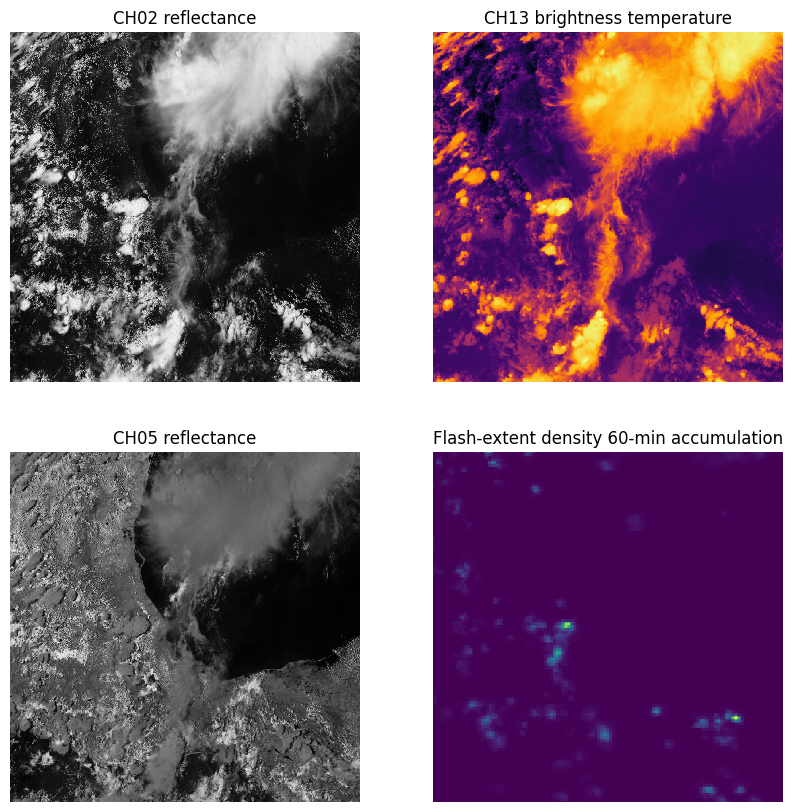

In [ ]:
tfrec = 'tfrecs/2022/20220828/goes16_20220828-200100_Y1010_X530.tfrec'

raw_dataset = tf.data.TFRecordDataset(tfrec)
parsed_dataset = raw_dataset.map(parse_tfrecord_fn)

for features in parsed_dataset.take(1):

  fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(10,10))
  for ii,ax in enumerate(axes.ravel()):
    ax.axis('off')
    if(ii==0):
      im = ax.imshow(unbytescale(features['CH02'].numpy(), bsinfo['CH02']['vmin'], bsinfo['CH02']['vmax']), interpolation='none', cmap=plt.get_cmap('Greys_r'))
      #plt.colorbar(im,ax=ax,orientation='horizontal',pad=0.03)
      ax.set_title('CH02 reflectance')
    elif(ii==1):
      im = ax.imshow(unbytescale(features['CH13'].numpy(), bsinfo['CH13']['vmin'], bsinfo['CH13']['vmax']), interpolation='none', cmap=plt.get_cmap('inferno_r'))
      ax.set_title('CH13 brightness temperature')
    elif(ii==2):
      im = ax.imshow(unbytescale(features['CH05'].numpy(), bsinfo['CH05']['vmin'], bsinfo['CH05']['vmax']), interpolation='none', cmap=plt.get_cmap('Greys_r'))
      ax.set_title('CH05 reflectance')
    else:
      ax.imshow(features['FED_accum_60min_2km'].numpy(), interpolation='none')
      ax.set_title('Flash-extent density 60-min accumulation')

  plt.show()

Hopefully you are able to see how lightning in the next hour (bottom right panel) corresponds with deep convection. You can notice a few things about the electrified clouds:

*   They are generally cold (yellow-orange in top right panel)
*   They are generally bright (white in the top left panel)
*   They are glaciated or glaciating (light gray cloud tops in bottom left panel)



## Training a Model <a name="training_model"></a>

### Defining the Model

We are almost ready to begin training a model. First, we need to define the model. We will use the popular and effective U-Net model from [Ronneberger et al. (2015)](https://arxiv.org/abs/1505.04597). The U-Net has an encoder-decoder structure. The skip connections ("copy and crop" in the image below") help to retain specificity in the resulting image, but they are not always necessary, depending on the problem.

![U-Net architecture](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*f7YOaE4TWubwaFF7Z1fzNw.png)


We will be upsampling the 2-km longwave-infrared ABI channels (CH13 and CH15) and the 1-km shortwave-infrared channel (CH05) to the spatial resolution of the visible channel (0.5 km).

Let's set up a dictionary with some important instructions and hyperparameters for the U-Net.

Note that we are using 4 encoding blocks, but only *two* decoding blocks. Our starting spatial resolution is 0.5 km, but we are ending with 2-km spatial resolution. We do this to reduce noise in the output, but also because our target field is at 2-km resolution.

Because we are trying to predict the probability of any lightning in the next hour, it is a binary classification problem. Thus, we use ["binary cross-entropy"](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a) as the loss function that we try to minimize.


<img src="https://androidkt.com/wp-content/uploads/2023/05/Selection_099.png" alt="binary cross-entropy" width="500" height="100">

In [ ]:
config = {}
config['input_tuples'] = [(1920,1920,1), (960,960,1), (480,480,2)] # Tensor shapes for our three inputs (0.5-km, 1-km, and 2-km)
                                                                   # Note that the last input has channels=2 (CH13 and CH15)
config['filter_width'] = 3
config['conv_activation'] = 'leaky_relu'
config['learning_rate'] = 0.001
config['batch_norm'] = True
config['dropout_rate'] = 0.0
config['dilation'] = 1 #default
config['padding'] = 'same'
config['ntargets'] = 1
config['num_encoding_blocks'] = 4
config['num_conv_per_block'] = 2
config['nfmaps_by_block'] = [16, 32, 64, 128, 256] #last element is for bottleneck of u-net
config['num_decoding_blocks'] = 2
config['optimizer'] = 'Adam'


#### Set up CSI metric

Here we set up the CSI metric, which we will use to evaluate the model.

In [ ]:
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K

#From https://arxiv.org/pdf/2106.09757.pdf
def csi(use_as_loss_function, use_soft_discretization,hard_discretization_threshold=None,name='csi'):
  def loss(target_tensor, prediction_tensor):
    if hard_discretization_threshold is not None:
      prediction_tensor = tf.where(prediction_tensor >= hard_discretization_threshold, 1., 0.)
    elif use_soft_discretization:
      prediction_tensor = K.sigmoid(prediction_tensor)

    target_tensor = tf.cast(target_tensor, tf.float32)
    num_true_positives = K.sum(target_tensor * prediction_tensor)
    num_false_positives = K.sum((1 - target_tensor) * prediction_tensor)
    num_false_negatives = K.sum(target_tensor * (1 - prediction_tensor))

    denominator = (num_true_positives + num_false_positives + num_false_negatives + K.epsilon())
    csi_value = num_true_positives / denominator

    if use_as_loss_function:
      return 1. - csi_value
    else:
      return csi_value

  loss.__name__ = name

  return loss
#----------------------------------------------------------------------------------------------------------------------------------
def get_metrics():

  csi05 = csi(use_as_loss_function=False, use_soft_discretization=False,hard_discretization_threshold=0.05,name='csi05')
  csi10 = csi(use_as_loss_function=False, use_soft_discretization=False,hard_discretization_threshold=0.1,name='csi10')
  csi15 = csi(use_as_loss_function=False, use_soft_discretization=False,hard_discretization_threshold=0.15,name='csi15')
  csi20 = csi(use_as_loss_function=False, use_soft_discretization=False,hard_discretization_threshold=0.2,name='csi20')
  csi25 = csi(use_as_loss_function=False, use_soft_discretization=False,hard_discretization_threshold=0.25,name='csi25')
  csi30 = csi(use_as_loss_function=False, use_soft_discretization=False,hard_discretization_threshold=0.3,name='csi30')
  csi35 = csi(use_as_loss_function=False, use_soft_discretization=False,hard_discretization_threshold=0.35,name='csi35')
  csi40 = csi(use_as_loss_function=False, use_soft_discretization=False,hard_discretization_threshold=0.4,name='csi40')
  csi45 = csi(use_as_loss_function=False, use_soft_discretization=False,hard_discretization_threshold=0.45,name='csi45')
  csi50 = csi(use_as_loss_function=False, use_soft_discretization=False,hard_discretization_threshold=0.5,name='csi50')

  metrics = ['accuracy',
               tf.keras.metrics.AUC(name='aupr',curve='PR'),
               tf.keras.metrics.MeanSquaredError(name='brier_score'),
               csi05,
               csi10,
               csi15,
               csi20,
               csi25,
               csi30,
               csi35,
               csi40,
               csi45,
               csi50]
  return metrics
#------------------------------------------------------------------------------------------------------------------------------------

#### U-Net definition

Now we have the U-Net definition.

In [ ]:
from tensorflow.keras.models import Model
import tensorflow.keras.optimizers

def unet_2D(config):

    input_tuples = config['input_tuples']
    filter_width = config['filter_width']
    conv_activation = config['conv_activation']
    learning_rate = config['learning_rate']
    batch_norm = config['batch_norm']
    dor = config['dropout_rate']
    dilation = config['dilation']
    padding = config['padding']
    ntargets = config['ntargets']
    optimizer = config['optimizer']

    incter = 0
    input_1 = L.Input((None,None,input_tuples[0][-1]),name=f'input_{incter}'); incter+=1
    inputs = [input_1]
    concat_inputs = [input_1]

    if(len(input_tuples) > 1): #we have multiple resolutions
      upsamp_res = int(input_tuples[0][-2] / input_tuples[1][-2])
      input_2 = L.Input(shape=(None,None,input_tuples[1][-1]),name=f'input_{incter}'); incter+=1
      inputs.append(input_2)
      input_2_interp = L.UpSampling2D(size=(upsamp_res,upsamp_res), data_format='channels_last')(input_2)
      concat_inputs.append(input_2_interp)
      if(len(input_tuples) > 2):
        upsamp_res = int(input_tuples[0][-2] / input_tuples[2][-2])
        input_3 = L.Input(shape=(None,None,input_tuples[2][-1]),name=f'input_{incter}'); incter+=1
        inputs.append(input_3)
        input_3_interp = L.UpSampling2D(size=(upsamp_res,upsamp_res), data_format='channels_last')(input_3)
        concat_inputs.append(input_3_interp)

      final_input = L.concatenate(concat_inputs)
    else:
      final_input = input_1

    num_encoding_blocks = config['num_encoding_blocks']
    num_conv_per_block = config['num_conv_per_block']
    nfmaps_by_block = config['nfmaps_by_block']
    num_decoding_blocks = config['num_decoding_blocks']

    # encoding branch
    to_concat = []
    for ii in range(num_encoding_blocks):
      nfmaps = nfmaps_by_block[ii]

      for jj in range(num_conv_per_block):
        first_block_input = final_input if(ii == 0 and jj == 0) else conv
        conv = L.Conv2D(nfmaps, filter_width, padding=padding, dilation_rate=dilation)(first_block_input)
        if(batch_norm): conv = L.BatchNormalization()(conv)
        conv = L.LeakyReLU()(conv) if(conv_activation == 'leaky_relu') else L.Activation(conv_activation)(conv)
        if(jj == num_conv_per_block - 1): #if last conv in the block
          to_concat.append(conv)
          conv = L.MaxPooling2D(pool_size=(2, 2))(conv)
          if(dor > 0): conv = L.Dropout(dor)(conv)

    # Middle / Bottleneck
    for jj in range(num_conv_per_block):
      conv = L.Conv2D(nfmaps_by_block[-1], filter_width, padding=padding, dilation_rate=dilation)(conv)
      if(batch_norm): conv = L.BatchNormalization()(conv)
      conv = L.LeakyReLU()(conv) if(conv_activation == 'leaky_relu') else L.Activation(conv_activation)(conv)

    # decoding branch
    for ii in range(num_decoding_blocks):
      nfmaps = nfmaps_by_block[-ii-1-1] #the extra -1 is because nfmaps_by_block[-1] is for the middle/bottleneck
      conv = L.Conv2DTranspose(nfmaps, filter_width, strides=2, padding=padding)(conv)

      conv = L.concatenate([conv,to_concat[-ii-1]], axis=-1) #This adds the skip connections

      if(dor > 0): conv = L.Dropout(dor)(conv)
      for jj in range(num_conv_per_block):
        conv = L.Conv2D(nfmaps, filter_width, padding=padding, dilation_rate=dilation)(conv)
        if(batch_norm): conv = L.BatchNormalization()(conv)
        conv = L.LeakyReLU()(conv) if(conv_activation == 'leaky_relu') else L.Activation(conv_activation)(conv)


    conv = L.Conv2D(ntargets, (1,1), bias_initializer='zeros')(conv)
    if(batch_norm): conv = L.BatchNormalization()(conv)
    conv = L.Activation('sigmoid')(conv)

    model = Model(inputs = inputs, outputs = conv)

    opt = getattr(tensorflow.keras.optimizers,optimizer)

    METRICS = get_metrics()

    model.compile(optimizer = opt(learning_rate = learning_rate), loss = 'binary_crossentropy', metrics = METRICS)

    print(model.summary())

    return model

### Training the Model

We set up our metrics and our model. Below are a few more helper functions that aid the training/evaluation process. Please read the comment strings to learn more. The `prepare_sample` function is particularly important.


In [ ]:
def prepare_sample(features):
  '''
  This function binarizes our truth data and gets the truth/target and
  ABI predictor data for this sample. We set up the inputs dict appropriately
  for how the model expects the data (i.e., three inputs).
  '''

  # binarize
  targetImage_int = features['FED_accum_60min_2km']
  zero = tf.zeros_like(targetImage_int)
  one = tf.ones_like(targetImage_int)
  # Note well that your binarization threshold should be in BYTESCALED space!
  # We scaled our lightning field from 0 to 255 flashes, to 0 to 255. Thus, anything over
  # 255 becomes 255. A flash count of "1" is scaled to "1". So, we are making
  # anything ≥ 1 to equal 1, and anything less than 1 to equal 0.
  targetImage = tf.where(targetImage_int >= 1, x=one, y=zero)

  inputs = {}

  inputs['input_0'] = features['CH02']
  inputs['input_1'] = features['CH05']
  ch13 = features['CH13']
  ch15 = features['CH15']
  inputs['input_2'] = tf.concat([ch13,ch15], axis=2)

  return inputs, targetImage
#-----------------------------------------------------------------------------------------------
def training_history_figs(history,outdir):
  '''
  This function simply makes a couple of figures for how the accuracy and loss
  changed during training.
  '''

  # summarize history for accuracy
  try:
    plt.plot(history['binary_accuracy'])
    if('val_binary_accuracy' in history): plt.plot(history['val_binary_accuracy'])
    plt.title('model binary accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    if('val_binary_accuracy' in history):
      plt.legend(['train', 'val'], loc='upper left')
    else:
      plt.legend(['train'], loc='upper left')
    plt.savefig(os.path.join(outdir,'binary_accuracy_history.png'))
    plt.close()
  except KeyError:
    plt.plot(history['accuracy'])
    if('val_accuracy' in history): plt.plot(history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    if('val_accuracy' in history):
      plt.legend(['train', 'val'], loc='upper left')
    else:
      plt.legend(['train'], loc='upper left')
    plt.savefig(os.path.join(outdir,'accuracy_history.png'))
    plt.close()

  # summarize history for loss
  plt.plot(history['loss'])
  if('val_loss' in history): plt.plot(history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  if('val_loss' in history):
    plt.legend(['train', 'val'], loc='upper left')
  else:
    plt.legend(['train'], loc='upper left')
  plt.savefig(os.path.join(outdir,'loss_history.png'))
  plt.close()
#--------------------------------------------------------------------------------------------------
def add_scores_to_file(outdir,scores={'val_aupr':{'best_score':0},'val_brier_score':{'best_score':1}}):
  '''
  Will append to {outdir}/verification_scores.txt or create it if it does not exist.
  If scores['score']['best_score'] = 0, then "higher_is_better" = True.
  If scores['score']['best_score'] = 1, then "higher_is_better" = False (i.e., lower is better).
  '''

  of = open(f'{outdir}/log.csv', 'r')
  lines = of.readlines()
  of.close()

  for ii,line in enumerate(lines):
    parts = line.split(',')
    if(ii == 0): #first line
      for score in scores:
        try:
          scores[score]['idx'] = parts.index(score) #set the score index
        except ValueError:
          del scores[score]  #remove score if it doesn't exist in the log.csv
        else:
          #set 'best_epoch' to initial epoch and if higher or lower is better
          scores[score]['best_epoch'] = 0
          if(scores[score]['best_score'] == 1): #indicates lower is better
            scores[score]['higher_is_better'] = False
          else:
            scores[score]['higher_is_better'] = True
    else: #All other lines
      for score in scores:
        idx = scores[score]['idx']
        best_val_score = scores[score]['best_score']
        val_score = float(parts[idx]) #the validation metric for this epoch
        if(scores[score]['higher_is_better']):
          if(val_score > best_val_score):
            scores[score]['best_score'] = val_score
            scores[score]['best_epoch'] = int(parts[0]) + 1
        else: #lower is better
          if(val_score < best_val_score):
            scores[score]['best_score'] = val_score
            scores[score]['best_epoch'] = int(parts[0]) + 1

  of = open(f'{outdir}/verification_scores.txt','a')
  for score in scores:
    best_score = scores[score]['best_score']
    best_epoch = scores[score]['best_epoch']
    of.write(f'Best {score}: {np.round(best_score,5)}; at epoch {best_epoch}\n')
  of.close()
  #------------------------------------------------------------------------------------------------

def get_best_model(outdir):

  best_model = 'foo'; best_loss = 999999

  models = glob.glob(f"{outdir}/model-*.h5")
  for mod in models:
    loss = float(os.path.basename(mod).split('-')[-1].split('.h5')[0])
    if(loss < best_loss):
      best_loss = loss
      best_model = mod

  if(best_model == 'foo'):
    print("Couldn't find best model. Returning last model.")
    try:
      return np.sort(models)[-1]
    except IndexError:
      raise
  else:
    return best_model

Now here is the code that we use to actually train the model.

`BATCHSIZE = 1` is simply due to resource limitations. Increase this as much as you can with your resources.

We create `tf.data.TFRecordDataset` objects. After shuffling the training dataset, we use `parse_tfrecord_fn` to extract the image features in *each* TFRecord (`.map` performs the function on each element). Then `prepare_sample` is called for each element in the dataset which simply organizes the inputs that the model expects (i.e., it expects three inputs: 0.5-km data, 1-km data, and 2-km data).

The validation dataset is like the training dataset, except shuffling is not necessary.

<hr>

#### ***Note well!***

There are several problems with our current data and set up.

*   Due to time and resource limitations, we only use 8 samples for training 6 samples for validation. This is not nearly enough data to generalize well.
*   The samples of the training and validation datasets are also too close in time. This autocorrelation can cause overfitting on certain features and a lack of generalization. It would be better to use samples from different days in each dataset, or ideally, different years.
*   Also due to time and resource limitations, we do not have a test dataset. It's imperative to have a test dataset so that you have a fully independent measure of how the model generalizes (no validation set used during training is fully independent from the training dataset; this is particularly true when you try to optimize hyperparameters).

I leave these important considerations as an exercise to the reader.



In [ ]:
!rm -rf model_output/test01/

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau

#-----------------------------------------------------------------------------------------------
#-------------------------------------DRIVING CODE----------------------------------------------
#-----------------------------------------------------------------------------------------------

BATCHSIZE = 1

outdir = 'model_output/test01/'
mkdir_p(outdir)

print('\nBuilding training Dataset')

AUTOTUNE=tf.data.AUTOTUNE

train_filenames = tf.io.gfile.glob("tfrecs/2022/20220828/goes16_20220828-20[0-3]*.tfrec") #FIXME
n_tsamples = len(train_filenames)
train_ds = (tf.data.TFRecordDataset(train_filenames, num_parallel_reads=AUTOTUNE)
           .shuffle(10)
           .map(parse_tfrecord_fn, num_parallel_calls=AUTOTUNE)
           .map(prepare_sample, num_parallel_calls=AUTOTUNE)
           .batch(BATCHSIZE)
           .prefetch(AUTOTUNE)
)

print('built training dataset')

print('\nBuilding validation Dataset')

val_filenames = tf.io.gfile.glob("tfrecs/2022/20220828/goes16_20220828-20[4-5]*.tfrec") #FIXME
n_vsamples = len(val_filenames)
val_ds = (tf.data.TFRecordDataset(val_filenames, num_parallel_reads=AUTOTUNE)
           .map(parse_tfrecord_fn, num_parallel_calls=AUTOTUNE)
           .map(prepare_sample, num_parallel_calls=AUTOTUNE)
           .batch(BATCHSIZE)
           .prefetch(AUTOTUNE)
)

# Callbacks
csvlogger = CSVLogger(f"{outdir}/log.csv", append=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=4) # If no improvement after {patience} epochs, the stop early
mcp_save = ModelCheckpoint(os.path.join(outdir,'model-{epoch:02d}-{val_loss:03f}.h5'),save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', cooldown=1, verbose=1, min_delta=0.00001,factor=0.1, patience=2, mode='min')
callbacks = [early_stopping, mcp_save, reduce_lr_loss, csvlogger]

conv_model = unet_2D(config)


# FIT THE MODEL
history = conv_model.fit(
          x=train_ds,
          verbose=1,
          epochs=100,
          validation_data=val_ds,
          callbacks=callbacks)
#shuffle has no effect if generator OR a tf.data.Dataset

print('Saving model and training history...')
#copy the model with the best val_loss
try:
  best_model = get_best_model(outdir)
except IndexError:
  print("Something is wrong with finding the best model. Exiting.")
  sys.exit()
else:
  shutil.copy(best_model,f"{os.path.dirname(best_model)}/fit_conv_model.h5")

# Save training history and make figs
pickle.dump(history.history,open(os.path.join(outdir,"training_history.pkl"),"wb"),protocol=4)
training_history_figs(history.history,outdir)

# Delete objects in RAM
del train_ds, history

# Create scores file
scores = {}
scores['val_aupr'] = {'best_score':0}
scores['val_brier_score'] = {'best_score':1}
scores['val_csi05'] = {'best_score':0}
scores['val_csi10'] = {'best_score':0}
scores['val_csi15'] = {'best_score':0}
scores['val_csi20'] = {'best_score':0}
scores['val_csi25'] = {'best_score':0}
scores['val_csi30'] = {'best_score':0}
scores['val_csi35'] = {'best_score':0}
scores['val_csi40'] = {'best_score':0}
scores['val_csi45'] = {'best_score':0}
scores['val_csi50'] = {'best_score':0}

add_scores_to_file(outdir,scores=scores)



Building training Dataset
built training dataset

Building validation Dataset
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 1)]      0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None, None, 2)]      0         []                            
                                                                                                  
 input_0 (InputLayer)        [(None, None, None, 1)]      0         []                            
                                                                                                  
 up_sampling2d_4 (UpSamplin  (None, None, None, 1)        0         ['input_1[0][0]']             
 g2D)        

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 79s 561ms/step - loss: 0.6394 - accuracy: 0.8631 - aupr: 0.3853 - brier_score: 0.2076 - csi05: 0.0757 - csi10: 0.0757 - csi15: 0.0757 - csi20: 0.0757 - csi25: 0.0757 - csi30: 0.0758 - csi35: 0.0766 - csi40: 0.1075 - csi45: 0.2053 - csi50: 0.2485 - val_loss: 1.8481 - val_accuracy: 0.7279 - val_aupr: 0.3402 - val_brier_score: 0.2761 - val_csi05: 0.0778 - val_csi10: 0.0778 - val_csi15: 0.0778 - val_csi20: 0.0778 - val_csi25: 0.0778 - val_csi30: 0.0804 - val_csi35: 0.1237 - val_csi40: 0.1595 - val_csi45: 0.1804 - val_csi50: 0.1916 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 62s 554ms/step - loss: 0.5821 - accuracy: 0.8959 - aupr: 0.4565 - brier_score: 0.1844 - csi05: 0.0757 - csi10: 0.0757 - csi15: 0.0757 - csi20: 0.0757 - csi25: 0.0757 - csi30: 0.0757 - csi35: 0.0844 - csi40: 0.1636 - csi45: 0.2552 - csi50: 0.2884 - val_loss: 0.6188 - val_accuracy: 0.8357 - val_aupr: 0.1862 - val_brier_score: 0.1865 - val_csi05: 0.0778 - v

#### Visualize training statistics

You now have a trained model! You can look at the loss history for both the training and validation sets.

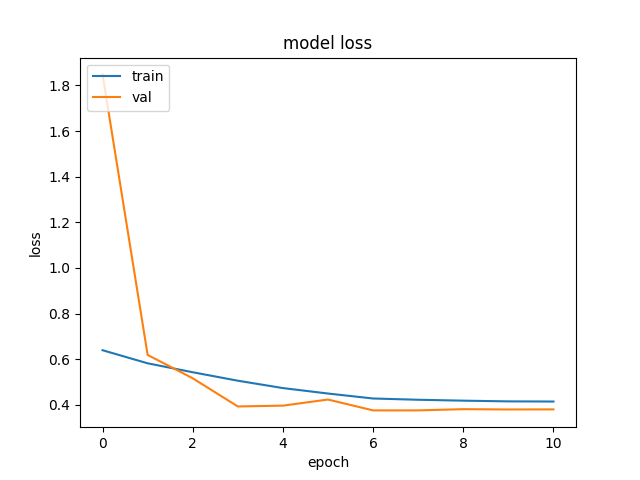

In [ ]:
from IPython.display import Image

# Path to the image
image_path = 'model_output/test01/loss_history.png'

# Display the image
Image(filename=image_path)

And the accuracy history as well.

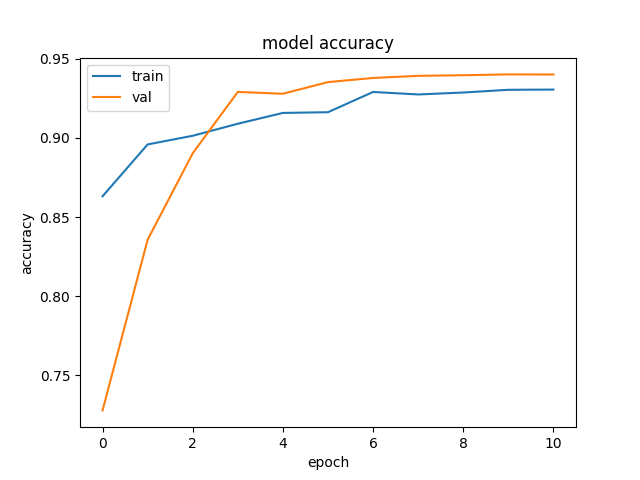

In [ ]:
# Path to the image
image_path = 'model_output/test01/accuracy_history.png'

# Display the image
Image(filename=image_path)

We can output the `verification_scores.txt` to see the best CSI (critical success index) at each probability level we supplied the model to track. Please keep in mind that this is a very small dataset, so somewhat erratic scores can be expected. Furthermore, there is a high degree of autocorrelation between the training and validation sets; thus, the scores may be artificially high.

In [ ]:
!cat model_output/test01/verification_scores.txt

Best val_aupr: 0.61415; at epoch 11
Best val_brier_score: 0.1012; at epoch 7
Best val_csi05: 0.0778; at epoch 1
Best val_csi10: 0.0778; at epoch 1
Best val_csi15: 0.0778; at epoch 1
Best val_csi20: 0.0778; at epoch 1
Best val_csi25: 0.07886; at epoch 5
Best val_csi30: 0.27226; at epoch 7
Best val_csi35: 0.35636; at epoch 7
Best val_csi40: 0.3617; at epoch 9
Best val_csi45: 0.35511; at epoch 6
Best val_csi50: 0.34869; at epoch 6


## Test on new data

Let's now see how the model does with new ABI data.

First retrieve the ABI data and make a list of tensors. Please note that because of how this model was constructed, each input dimension of the 2-km data much be divisible by 4. This is a function of the number of convolutional layers, blocks, filter width, etc.

In [ ]:
# Get ABI data for new datetime

abidt = datetime(2023,8,31,17,1)

# We will use this data indices to look only at a patch of the data.
# This patch is over Florida, and the indices were found a priori.
# These patch indices are valid for 2-km data
x1,x2 = (1200,1600)
y1,y2 = (652,1000)


#CH02
file_location = fs.glob(abidt.strftime('s3://noaa-goes16/ABI-L1b-RadC/%Y/%j/%H/*C02*_s%Y%j%H%M*.nc'))
file_ob = [fs.open(file) for file in file_location]
ds = xr.open_mfdataset(file_ob,combine='nested',concat_dim='time')
ch02 = ds['Rad'][0,y1*4:y2*4,x1*4:x2*4].data.compute()
ch02 = ch02 * ds['kappa0'].data[0] # Convert to reflectance
ch02 = np.expand_dims(bytescale(ch02,bsinfo['CH02']['vmin'],bsinfo['CH02']['vmax']), axis=-1) #bytescale and add channels dim

#CH05
file_location = fs.glob(abidt.strftime('s3://noaa-goes16/ABI-L1b-RadC/%Y/%j/%H/*C05*_s%Y%j%H%M*.nc'))
file_ob = [fs.open(file) for file in file_location]
ds = xr.open_mfdataset(file_ob,combine='nested',concat_dim='time')
ch05 = ds['Rad'][0,y1*2:y2*2,x1*2:x2*2].data.compute()
ch05 = ch05 * ds['kappa0'].data[0] # Convert to reflectance
ch05 = np.expand_dims(bytescale(ch05,bsinfo['CH05']['vmin'],bsinfo['CH05']['vmax']), axis=-1) #bytescale and add channels dim

#CH13
file_location = fs.glob(abidt.strftime('s3://noaa-goes16/ABI-L1b-RadC/%Y/%j/%H/*C13*_s%Y%j%H%M*.nc'))
file_ob = [fs.open(file) for file in file_location]
ds = xr.open_mfdataset(file_ob,combine='nested',concat_dim='time')
ch13 = ds['Rad'][0,y1:y2,x1:x2].data.compute()
# Convert to brightness temperature
# First get some constants
planck_fk1 = ds['planck_fk1'].data[0]; planck_fk2 = ds['planck_fk2'].data[0]; planck_bc1 = ds['planck_bc1'].data[0]; planck_bc2 = ds['planck_bc2'].data[0]
ch13 = (planck_fk2 / (np.log((planck_fk1 / ch13) + 1)) - planck_bc1) / planck_bc2
ch13 = np.expand_dims(bytescale(ch13,bsinfo['CH13']['vmin'],bsinfo['CH13']['vmax']), axis=-1) #bytescale and add channels dim

#CH15
file_location = fs.glob(abidt.strftime('s3://noaa-goes16/ABI-L1b-RadC/%Y/%j/%H/*C15*_s%Y%j%H%M*.nc'))
file_ob = [fs.open(file) for file in file_location]
ds = xr.open_mfdataset(file_ob,combine='nested',concat_dim='time')
ch15 = ds['Rad'][0,y1:y2,x1:x2].data.compute()
# Convert to brightness temperature
# First get some constants
planck_fk1 = ds['planck_fk1'].data[0]; planck_fk2 = ds['planck_fk2'].data[0]; planck_bc1 = ds['planck_bc1'].data[0]; planck_bc2 = ds['planck_bc2'].data[0]
ch15 = (planck_fk2 / (np.log((planck_fk1 / ch15) + 1)) - planck_bc1) / planck_bc2
ch15 = np.expand_dims(bytescale(ch15,bsinfo['CH15']['vmin'],bsinfo['CH15']['vmax']), axis=-1) #bytescale and add channels dim

# Here we add the "samples" dimension as the 0th dimension for each input.
inputs = [np.expand_dims(ch02,axis=0), np.expand_dims(ch05,axis=0), np.expand_dims(np.concatenate((ch13,ch15),axis=-1),axis=0)]

Now let's make predictions!

In [ ]:
from tensorflow.keras.models import load_model

# Load our model
model = 'model_output/test01/fit_conv_model.h5'
conv_model = load_model(model,compile=False) # Compile is False because we aren't training right now. We're inferencing.

preds = conv_model.predict(inputs,verbose=1)   # Making the predictions
preds = np.squeeze(preds)                     # Remove sample and channel dims

1/1 [==============================] - 0s 498ms/step


And here are our predictions. They are probabilities, so we scale between 0 and 1.

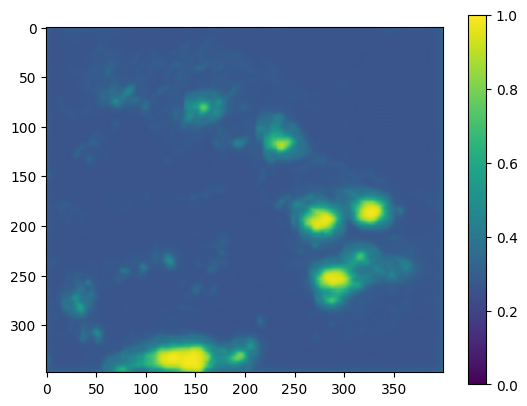

In [ ]:
plt.imshow(preds,vmin=0,vmax=1)
plt.colorbar()

It looks like the predictions might be a little too high everywhere, even in clear sky.

Let's get some GLM data to compare against our predictions.

In [ ]:
%cd glmL2

download_glm_files('s3://noaa-goes16/GLM-L2-LCFA/2023/243/16/OR_GLM-L2-LCFA_G16_s2023243165[7-9]*.nc')
download_glm_files('s3://noaa-goes16/GLM-L2-LCFA/2023/243/17/OR_GLM-L2-LCFA_G16_s2023243170[0,1]*.nc')

%cd ..

/content/glmL2
/content


Create the 1-min accumulation files, and then make a 5-minute accumulation file. This file will contain a sum of flashes at each point in the 5 minutes previous to the ABI scan time (1701 UTC).

In [ ]:
# Make 1-min accumulations for 31 August 2023 1657-1701Z
!/usr/local/envs/glmval/bin/python glmtools/examples/grid/make_GLM_grids.py -o glmL3/1min/{start_time:%Y/%b/%d}/{dataset_name} \
  --fixed_grid --split_events --goes_position=east --goes_sector=conus --dx=2.0 --dy=2.0 \
  glmL2/*s2023243*.nc

In [ ]:
# Make 5-min max accumulation

datadir = 'glmL3/1min/'
outdir = 'glmL3/60min'

dt = datetime(2023,8,31,17,0)

lastdt_str = dt.strftime('%Y%j%H%M')
aggregate_glm_grids(lastdt_str,datadir,accumPeriod=5,outdir=outdir)


Process started
Process started
Wrote out glmL3/60min/agg/20230831-170100.netcdf


Now plot the GLM data, along with ABI CH13 brightness temperature in the background, and with contours of the model's probability of lightning in the next hour.

Text(0.5, 1.0, 'GOES-16 Probability of Lightning and Flash-Extent Density 31-08-2023 17:00 UTC')

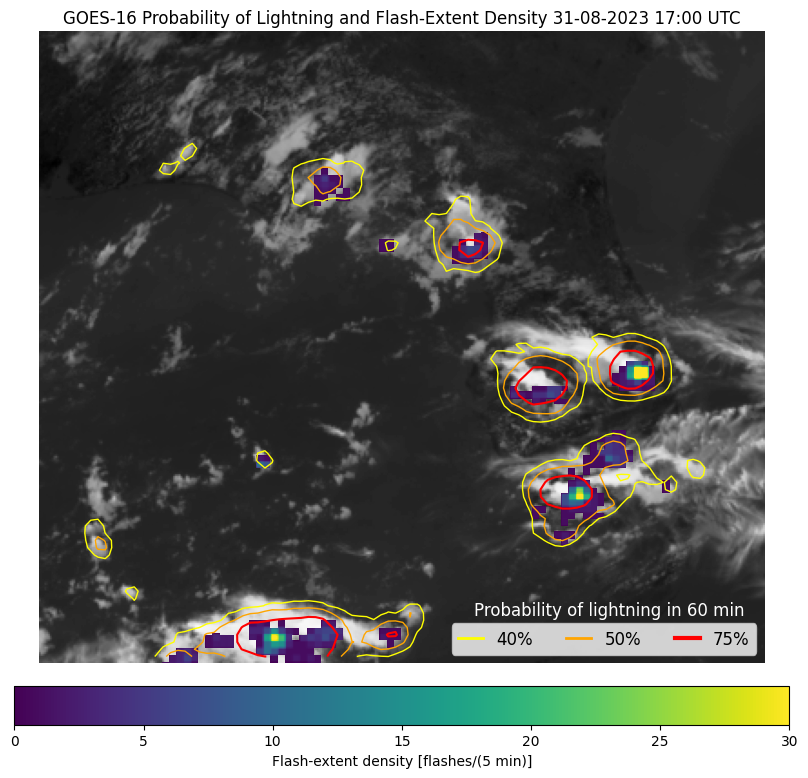

In [ ]:
# Get GLM data
nc = netCDF4.Dataset('glmL3/60min/agg/20230831-170100.netcdf')
fed = nc.variables['flash_extent_density'][y1:y2,x1:x2]   # We use the 2-km indices of ABI because this is on the same fixed grid
nc.close()

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))
plt.axis('off')

sat = plt.imshow(np.squeeze(ch13),cmap=plt.get_cmap('Greys'))
im = plt.imshow(fed,vmin=0,vmax=30)

from matplotlib.lines import Line2D
colors = ['yellow','orange','red']
linewidths = [1,1,1.5]
levels=[0.4, 0.5, 0.75]
labels = [str(int(l*100))+'%' for l in levels]

# This block is for subsampling or "smoothing" the predictions
preds_ny,preds_nx = preds.shape
x=np.arange(0,preds_nx,4)
y=np.arange(0,preds_ny,4)
x,y = np.meshgrid(x,y)
sub_sampled_preds = preds[::4,::4]

plt.contour(x,y, sub_sampled_preds, levels=levels, colors=colors, linewidths=linewidths)
#contour legend
custom_lines = [Line2D([0],[0], color=c, lw=lw*2) for c, lw in zip(colors,linewidths)]
leg = plt.legend(custom_lines, labels, fontsize=12,loc="lower right",handlelength=1.5,ncol=3)
prob_label = "Probability of lightning in 60 min"
ctext = plt.text(0.6,0.075,prob_label,fontsize=12,color="white",transform=ax.transAxes)

plt.colorbar(im,orientation='horizontal',label='Flash-extent density [flashes/(5 min)]',pad=0.03)
plt.title(f'GOES-16 Probability of Lightning and Flash-Extent Density {dt.strftime("%d-%m-%Y %H:%M UTC")}')


## Final Thoughts

This plot shows current lightning activity along with the probability of lightning in the next 60 minutes. The background is 10.3-µm brightness temperature from GOES-16. This scene is over the Florida peninsula.

While we could generate and plot next-hour lightning, this example will serve as a sanity check that the model is correctly predicting high probabilities where we already have lightning.

The good news is that higher probabilities generally correspond to areas of high flash rates. This means that our model learned about the short-term persistence of storms, at least to some degree!

The bad news is that overall, the probabilities are way too high. Almost eveything is above 35%. But don't be too discouraged--we only trained on 8 highly correlated samples!

Hopefully in this notebook you learned more about:
*   How to access GOES-R ABI and GLM data from the AWS cloud
*   How to use `glmtools` to create gridded fields such as flash-extent density
*   How to create a U-Net model using `tensorflow`
*   How to generate TFRecords
*   How to visualize your predictions



<hr>

# Exercises

1. Try plotting data for a different date, time, or location
1. Try including CH16 as a predictor
   *   You will need to add scaling units for this channel in `bsinfo`.
   *   You will need to add a block for CH16 in the ["Creating full samples / patches"](#create_samples) and re-create TFRecords.
   *   Make sure you add CH16 as a new channel in the 2-km input you supply to the model.
1. See how the model improves when you use more data samples
   *   How do things change when your training data and validation data are no longer autocorrelated?
       *   Make sure your new data are from different dates.
1. Use flash-extent density and/or total optical energy from GLM as *predictors*.

<hr>

# Metadata
* Language / package(s)
   * Python
   * tensorflow
* Domain
   * NWS
* Application keywords
   * Nowcasting
* Geophysical keywords
   * lightning
* Data keywords
   * GOES-R ABI
   * GOES-R GLM
* AI keywords
   * Convolutional Neural Network
   * U-Net
